# Dynamo checking

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import dynamo as dyn

## Version checking

In [2]:
dyn.get_all_dependencies_version()

package umap-learn typing-extensions    tqdm statsmodels setuptools   
version      0.5.3             4.5.0  4.65.0      0.14.0     66.0.0  \

package session-info seaborn   scipy scikit-learn python-igraph pynndescent   
version        1.0.0  0.12.2  1.10.1        1.2.2        0.10.4      0.5.10  \

package pre-commit pandas openpyxl   numpy numdifftools   numba networkx   
version      3.3.1  2.0.1    3.1.2  1.24.3       0.9.41  0.57.0    2.8.4  \

package matplotlib loompy get-version dynamo-release colorcet  cdlib anndata  
version      3.7.1  3.0.7       3.5.4          1.2.0    3.0.1  0.2.6   0.9.1

## Preprocessing checking

In [27]:
adata = dyn.sample_data.zebrafish()
adata

|-----> Downloading data to ./data/zebrafish.h5ad


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    layers: 'spliced', 'unspliced'

In [28]:
preprocessor = dyn.pp.Preprocessor(cell_cycle_score_enable=True)
preprocessor.preprocess_adata(adata, recipe='monocle') # recipe: 'monocle', 'seurat', 'sctransform', 'pearson_residuals', 'monocle_pearson_residuals'
# adata = adata[adata.obs["pass_basic_filter"], adata.var["pass_basic_filter"]]
adata

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 14 outlier cells
|-----------> filtered out 12746 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [22.0305s]
|-----> [Cell Cycle Scores Estimation] completed [0.1355s]
|-----> [Preprocessor-monocle] completed [1.4294s]


AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'frac', 'use_for_pca', 'ntr'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'cell_phase_genes'
    obsm: 'X_pca', 'cell_cycle_scores'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced'

## PCA&UMAP checking

|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [6.9859s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


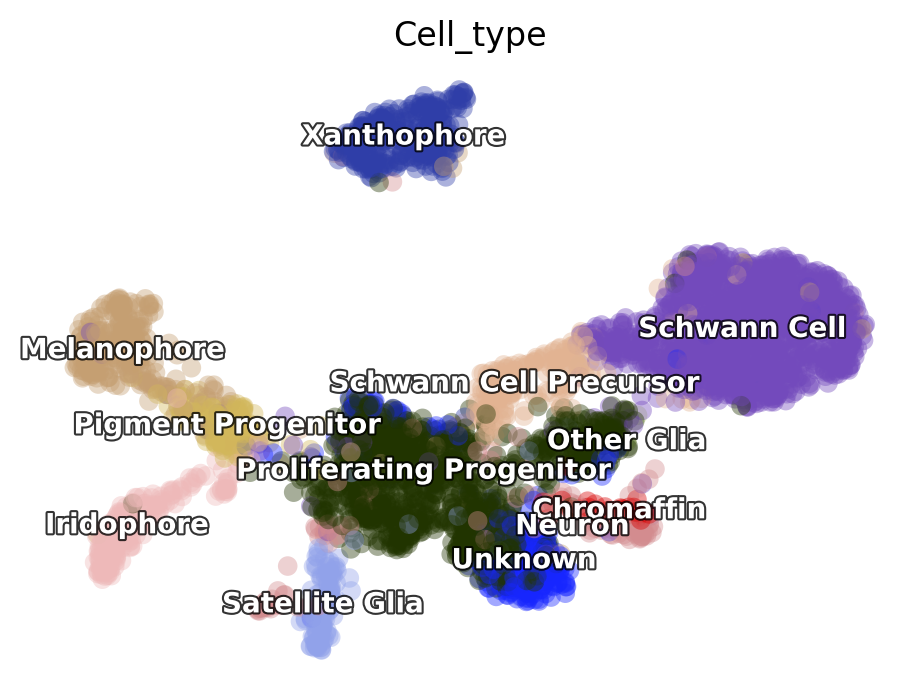

In [29]:
dyn.tl.reduceDimension(adata, basis="pca")
dyn.pl.umap(adata, color="Cell_type", pointsize=0.2, alpha=0.4)

## Clustering checking

|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----> [Community clustering with leiden] completed [210.2688s]
|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----? louvain is not maintained, we recommend using leiden instead.
|-----> [Community clustering with louvain] completed [0.1325s]
|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igrap

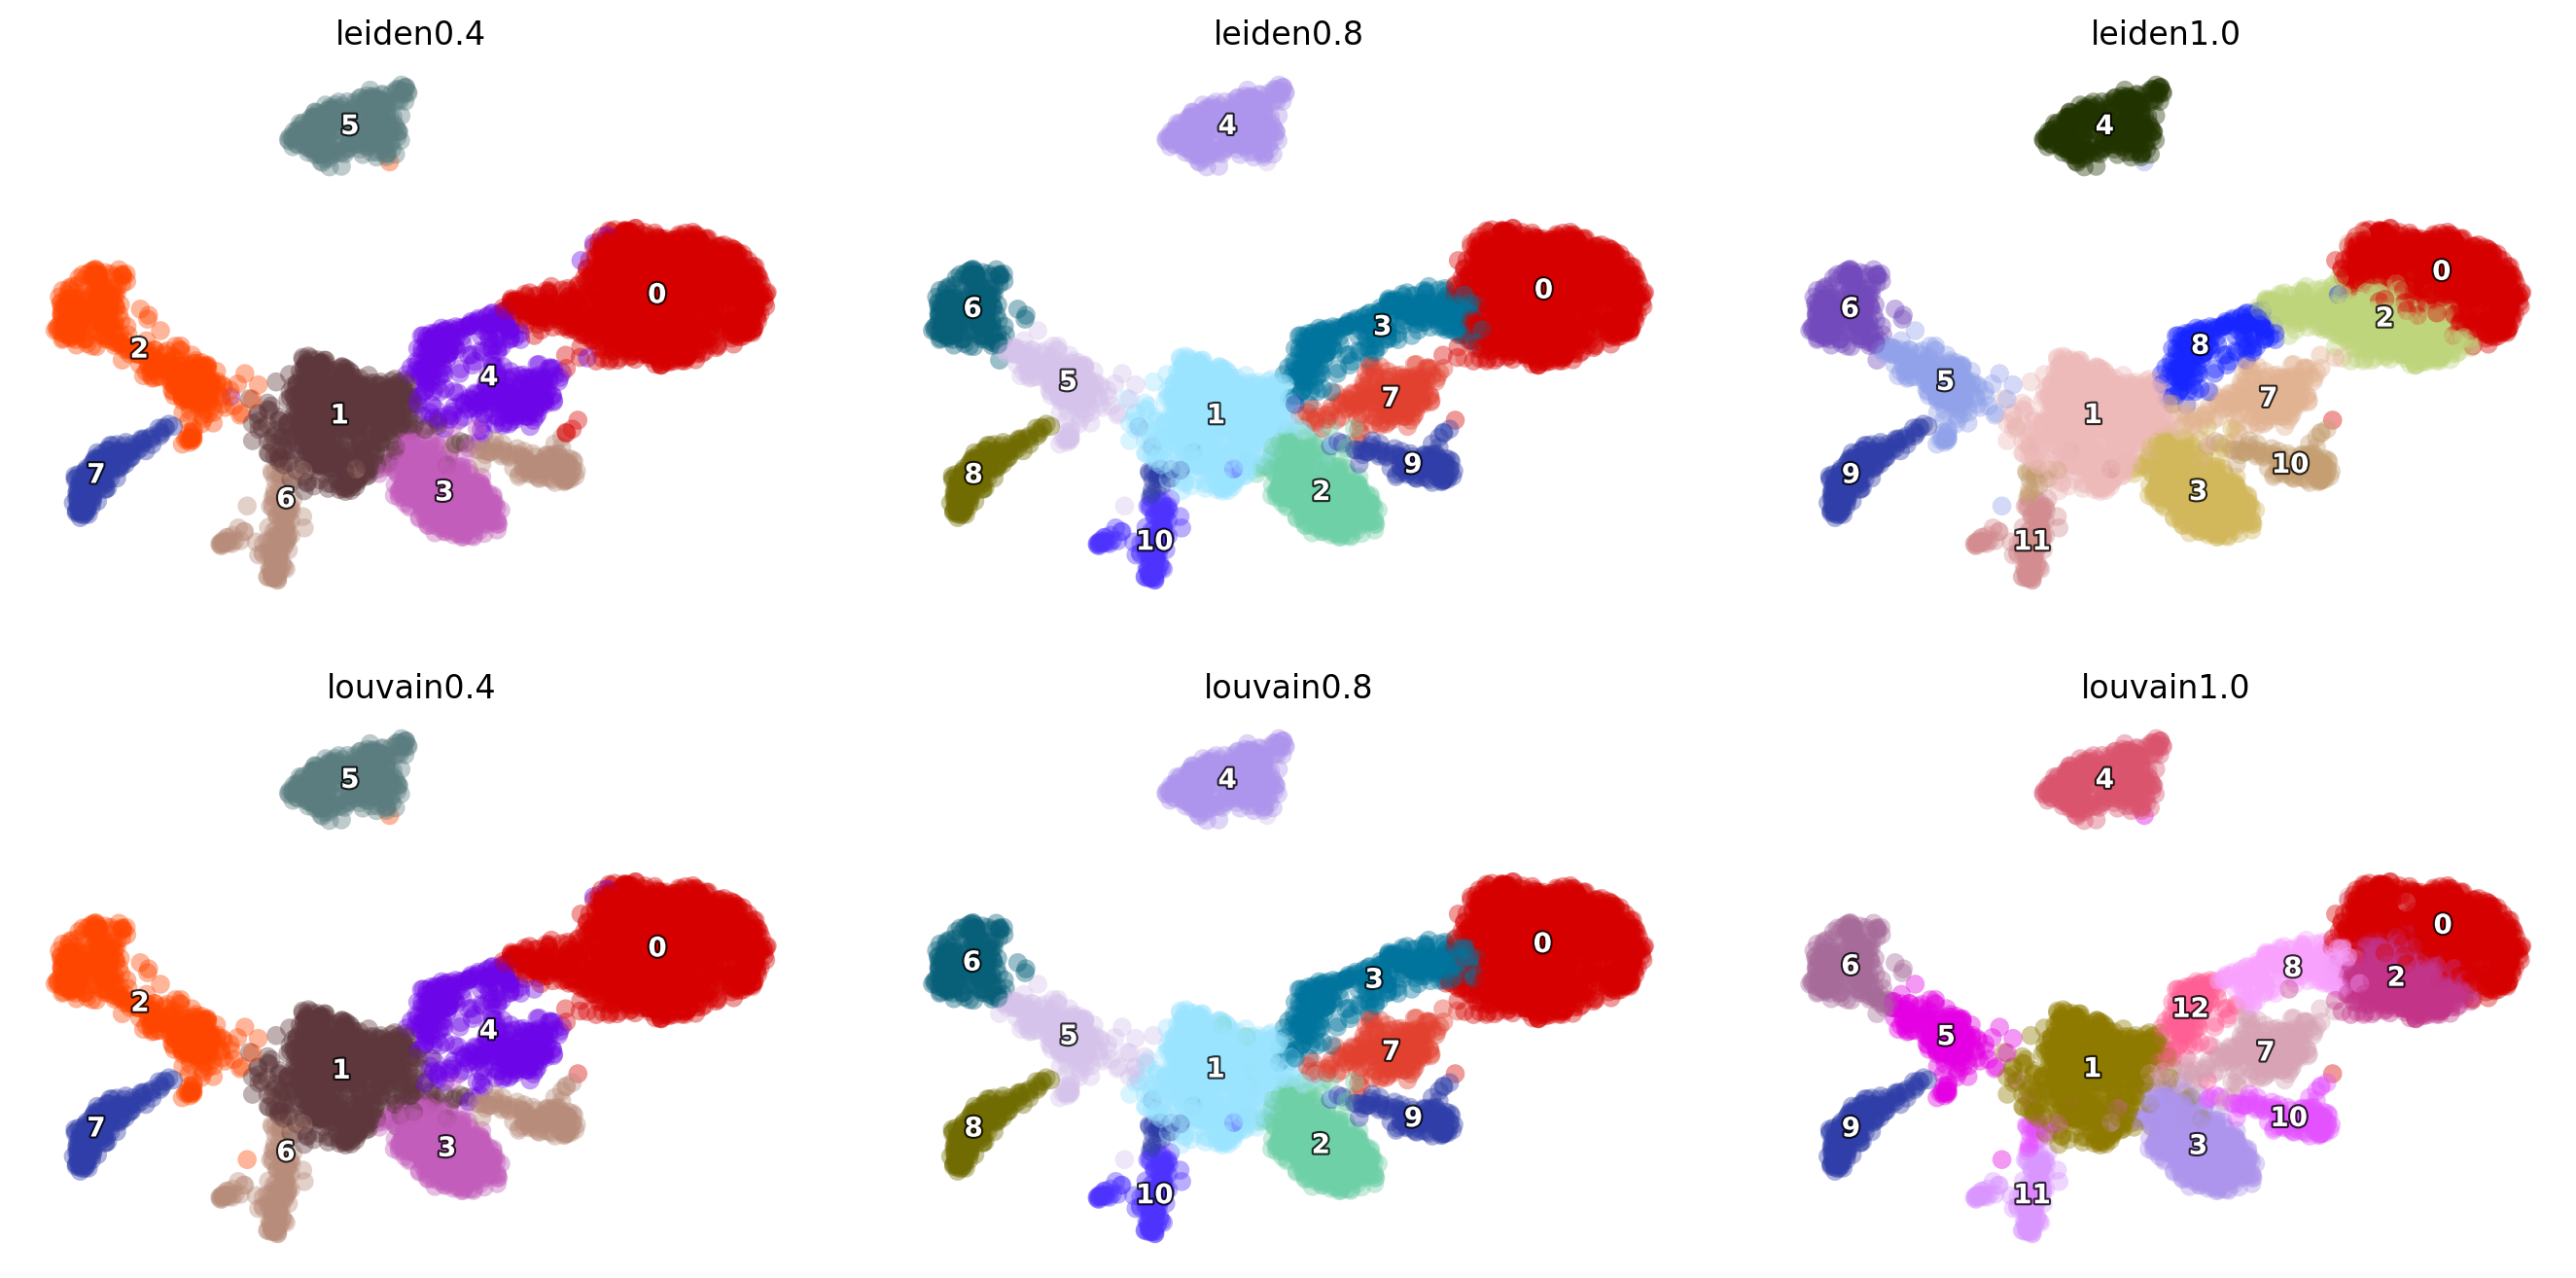

In [30]:
for res in [0.4, 0.8, 1.0]:
    dyn.tl.leiden(adata, resolution=res, result_key=f"leiden{res}")
    dyn.tl.louvain(adata, resolution=res, result_key=f"louvain{res}")
dyn.pl.umap(adata, color=["leiden0.4", "leiden0.8", "leiden1.0", "louvain0.4", "louvain0.8", "louvain1.0",], pointsize=0.2, alpha=0.4, ncols=3)

## RNA velocity checking

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] completed [6.2996s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [1.2368s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3287s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


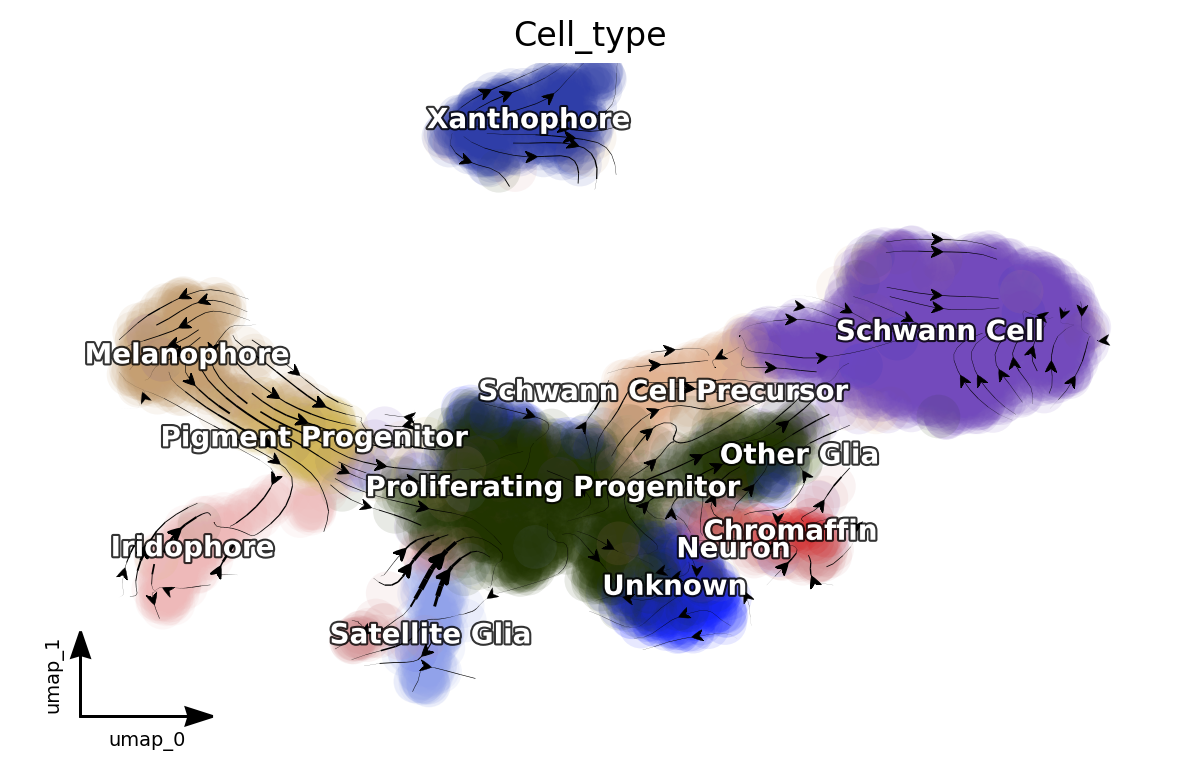

In [31]:
dyn.tl.dynamics(adata, model='deterministic', cores=3)
dyn.tl.cell_velocities(adata, method='pearson', other_kernels_dict={'transform': 'sqrt'})
dyn.pl.streamline_plot(adata, color=['Cell_type'], basis='umap', show_legend='on data', show_arrowed_spines=True)

## VectorField checking

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [10.9270s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 1-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [8.0448s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 2-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [6.3837s]
|

Calculating 2-D curl: 100%|██████████| 4167/4167 [00:00<00:00, 36792.99it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 5/5 [00:00<00:00, 66.46it/s]


|-----> [VectorField] completed [50.8711s]


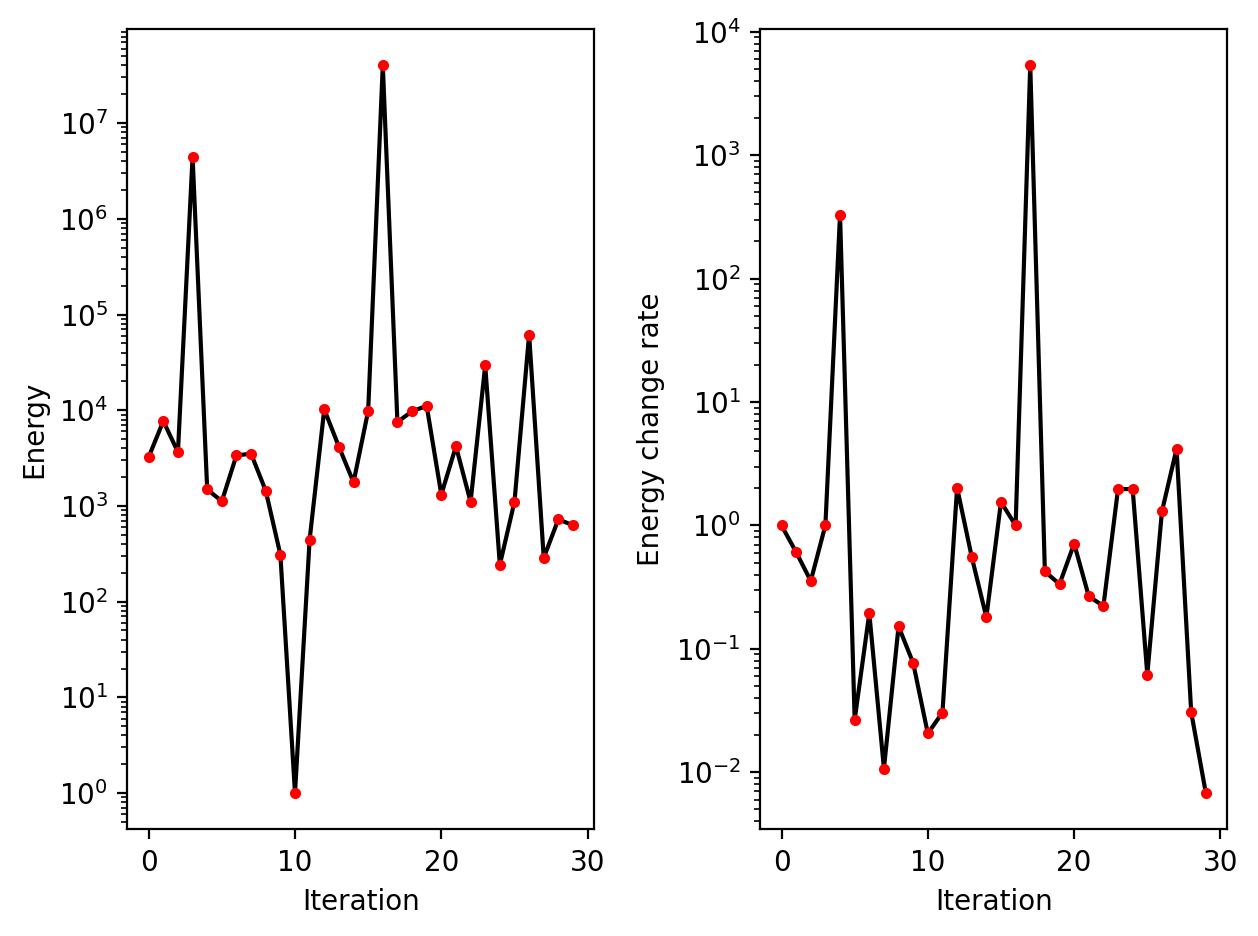

In [32]:
dyn.vf.VectorField(adata, basis='umap', M=1000, pot_curl_div=True)
dyn.pl.plot_energy(adata, basis='umap')

|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


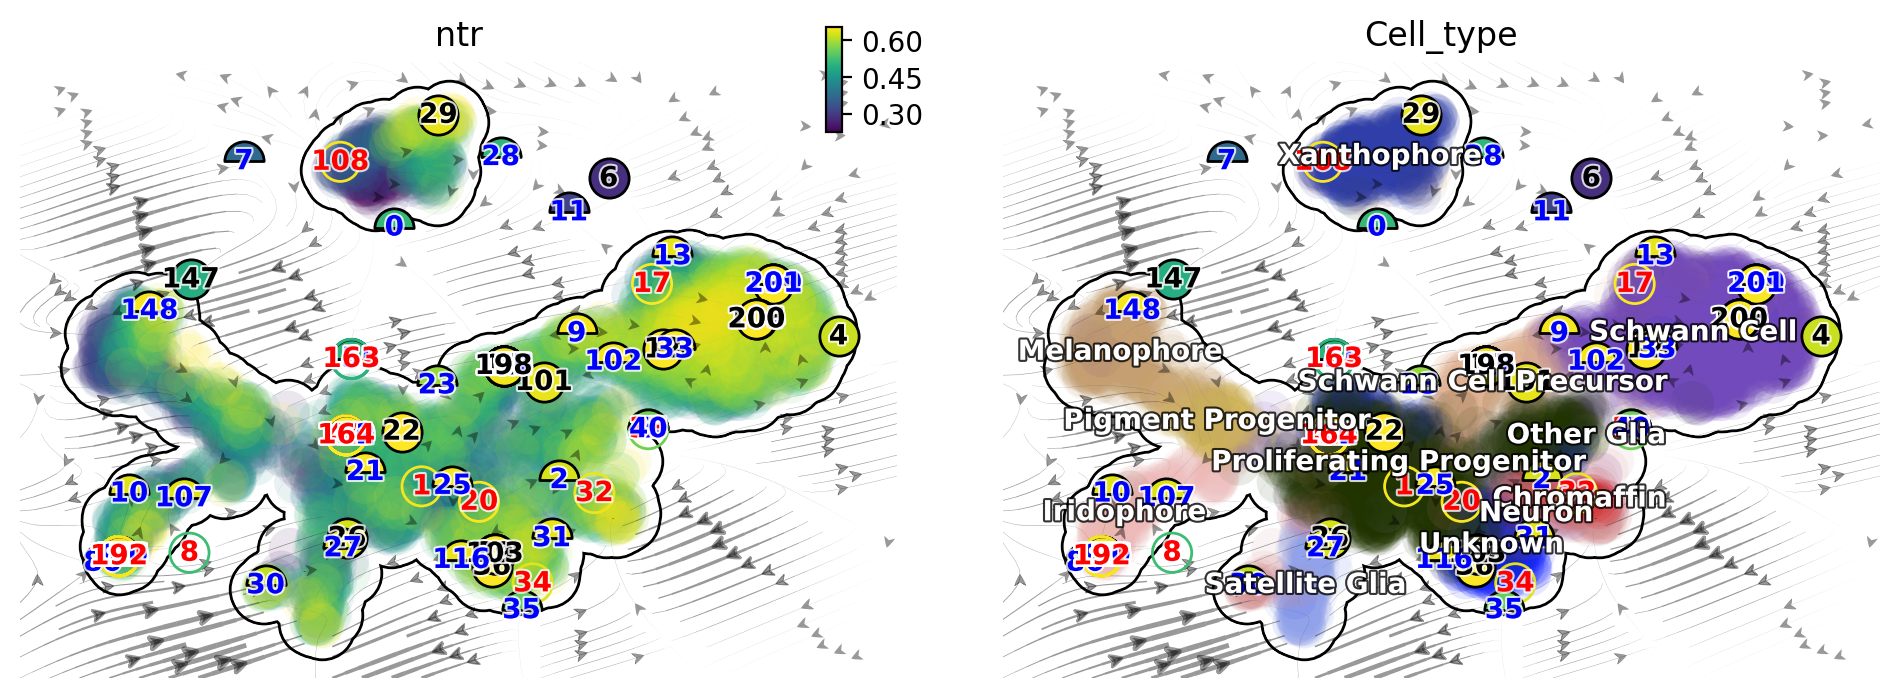

In [33]:
dyn.pl.topography(adata, basis='umap', background='white', color=['ntr', 'Cell_type'], streamline_color='black', show_legend='on data', frontier=True)

## Beyond RNA velocity checking

In [34]:
dyn.tl.cell_velocities(adata, basis='pca')
dyn.vf.VectorField(adata, basis='pca')
dyn.vf.speed(adata, basis='pca')
dyn.vf.curl(adata, basis='umap')
dyn.vf.divergence(adata, basis='pca')
dyn.vf.acceleration(adata, basis='pca')
dyn.vf.curvature(adata, basis='pca')

|-----> 0 genes are removed because of nan velocity values.
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [1.1281s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.8272s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 1-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [1.2486s]
|-----------> current cosine correlation between input velocities and learned 

Calculating divergence: 100%|██████████| 5/5 [00:00<00:00, 29.55it/s]


|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.0351s]
|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.0437s]
|-----> [Calculating curvature] in progress: 100.0000%|-----> [Calculating curvature] completed [0.0387s]


|-----> X shape: (4167, 2) V shape: (4167, 2)
|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap


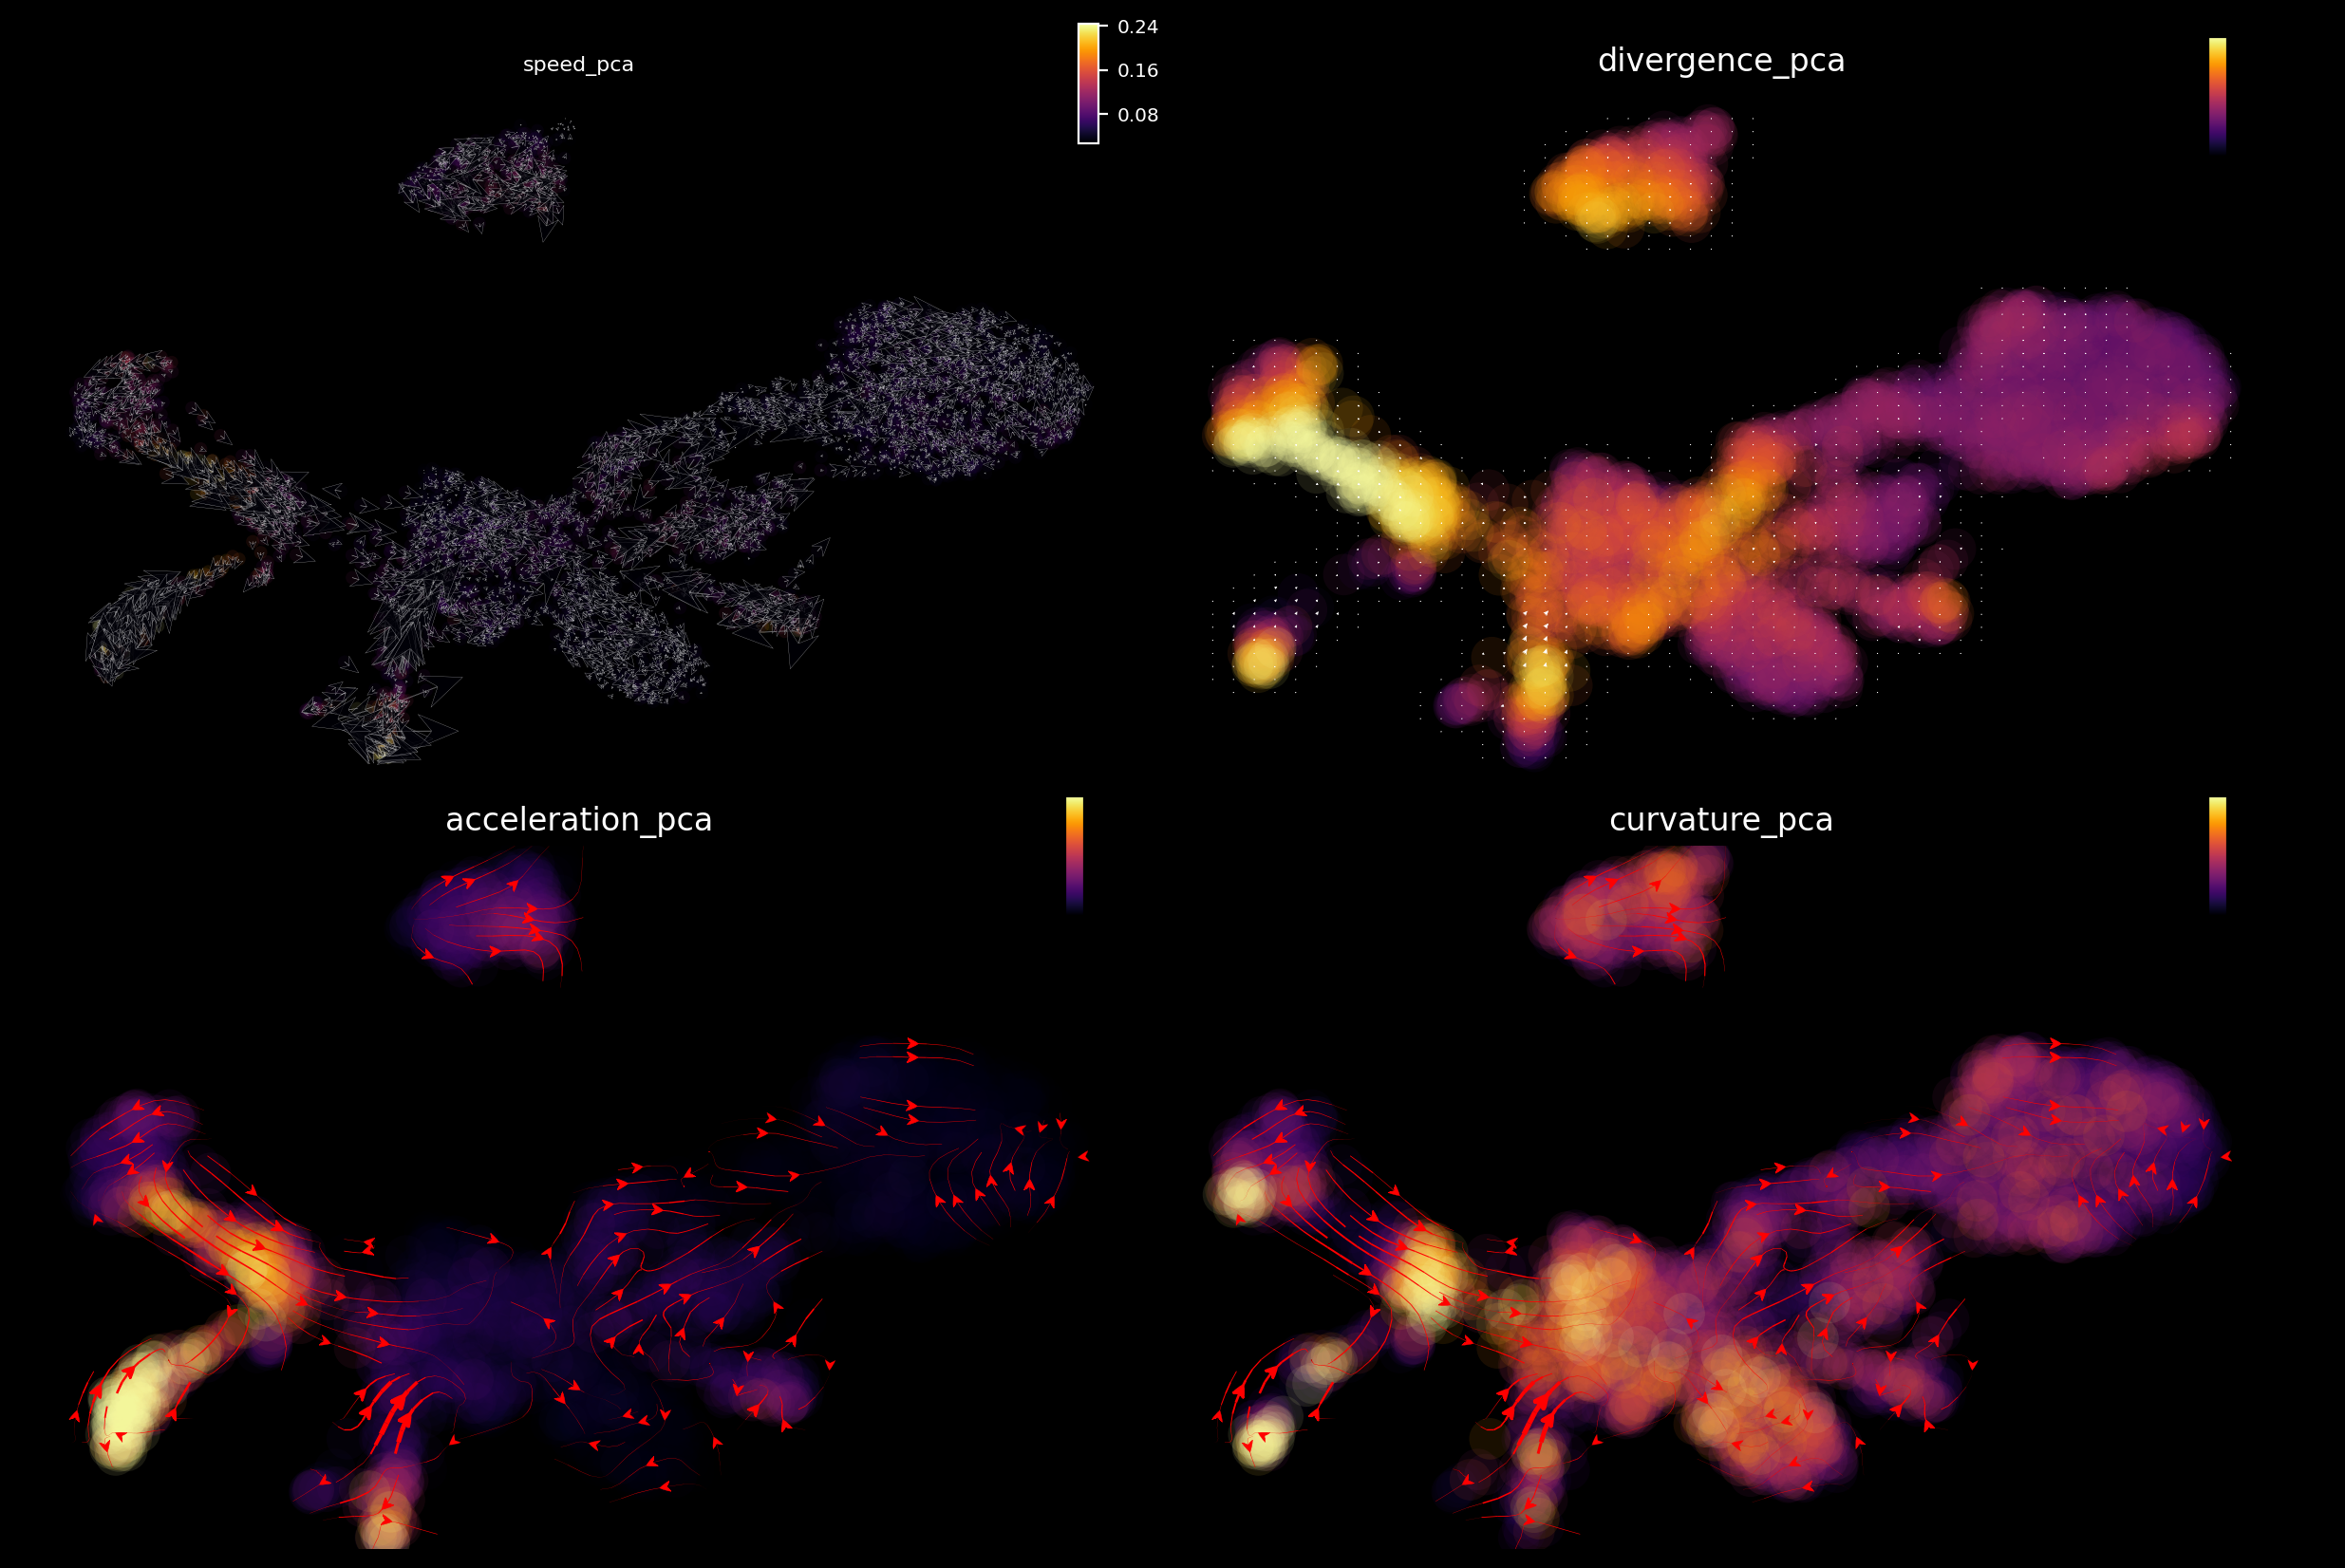

In [38]:
import matplotlib.pyplot as plt
dyn.configuration.set_figure_params('dynamo', background='black')
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(12, 8))
f1_axes[0, 0] = dyn.pl.cell_wise_vectors(adata, color='speed_pca', pointsize=0.1, alpha = 0.7, ax=f1_axes[0, 0], quiver_length=6, quiver_size=6, save_show_or_return='return', background='black')
f1_axes[0, 1] = dyn.pl.grid_vectors(adata, color='divergence_pca', ax=f1_axes[0, 1], quiver_length=12, quiver_size=12, save_show_or_return='return', background='black')
f1_axes[1, 0] = dyn.pl.streamline_plot(adata, color='acceleration_pca', ax=f1_axes[1, 0], save_show_or_return='return', background='black')
f1_axes[1, 1] = dyn.pl.streamline_plot(adata, color='curvature_pca', ax=f1_axes[1, 1], save_show_or_return='return', background='black')
plt.show()